In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
  

import tensorflow as tf
import sklearn

import codecs
from tqdm import tqdm

In [ ]:
raw = pd.read_csv('/content/drive/MyDrive/P7/training.1600000.processed.noemoticon.csv',encoding='latin-1', header=None)

##Analyse exploratoire

In [ ]:
raw

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
raw.describe()

,0,1
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


La target est de 0 ou de 4 :
0 -> Sentiment négatif
4 -> Sentiment positif

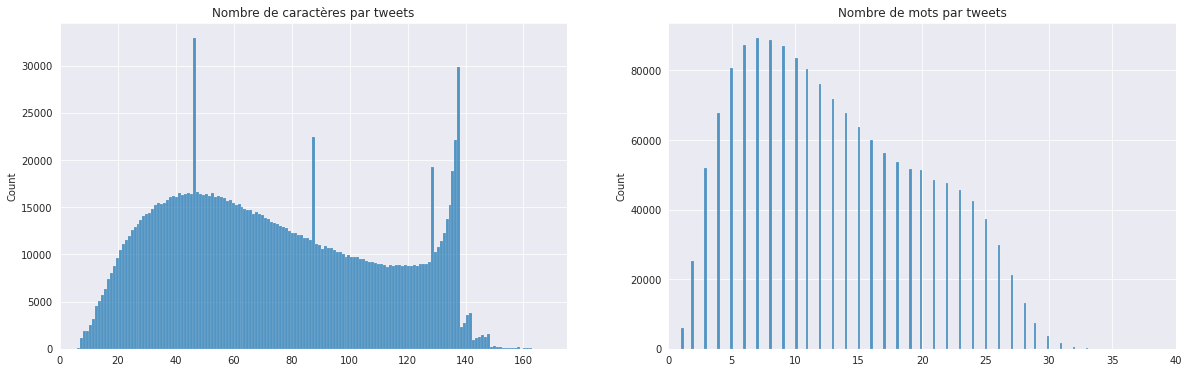

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sns.set_style('darkgrid')
        
list_nb_characters = [len(x) for x in raw[5]]
list_nb_of_words = [len(x.split()) for x in raw[5]]

ax1.set_title('Nombre de caractères par tweets')
sns.histplot(list_nb_characters, ax = ax1)
ax1.set_xlim([0, 175])

ax2.set_title('Nombre de mots par tweets')
sns.histplot(list_nb_of_words, ax = ax2)
ax2.set_xlim([0, 40])

plt.show()

Rien de notable a en tirer si ce n'est que nos données ne présente aucune anomalie visible

## Echantillonage

On prend un échantillon le dataset étant très grand. On prend autant de target = 4 que de target = 0 afin d'avoir un echantillon équilibré

In [ ]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [ ]:
df = stratified_sample_df(raw, 0, 100000).reset_index(drop=True)
df

,0,1,2,3,4,5
0,0,2251355041,Sat Jun 20 03:14:05 PDT 2009,NO_QUERY,TracyLynn78,@JonathanRKnight couldnt afford 2make it out 2...
1,0,2261594725,Sat Jun 20 21:02:08 PDT 2009,NO_QUERY,meganeliza,I hate when it's too hot to hide from the worl...
2,0,2187247392,Mon Jun 15 20:00:23 PDT 2009,NO_QUERY,phattie_V,not feeling goood anybody ever drunk v8 n it m...
3,0,1974394194,Sat May 30 13:02:52 PDT 2009,NO_QUERY,JessInOttawa,Arghhh I wish this headache would go away I a...
4,0,2203278744,Tue Jun 16 23:23:38 PDT 2009,NO_QUERY,livnb,trying to calll bradie..but hees number is bus...
...,...,...,...,...,...,...
199995,4,1973586553,Sat May 30 11:26:31 PDT 2009,NO_QUERY,xsteffenx,@caramelthighsxo ill put you name on just say ...
199996,4,1970903287,Sat May 30 05:36:21 PDT 2009,NO_QUERY,stargatejohn,Qt inlaws. Going to take pics ready for tom as...
199997,4,2052657546,Sat Jun 06 01:31:11 PDT 2009,NO_QUERY,NurulAyn07,Just had Hot wedges and hot sauce.yummiii..
199998,4,1879996685,Thu May 21 23:46:35 PDT 2009,NO_QUERY,caitiebecker,@emilyhayes is that why you carry smaller purs...


## Nettoyage du dataset

On supprime les colonnes inutiles et donne un nom aux colonnes que l'on garde

In [ ]:
df.rename(columns = {0:'target', 5:'text'}, inplace = True)

In [ ]:
df = df.drop([1, 2, 3, 4], axis=1)

In [ ]:
df.head()

,target,text
0,0,@JonathanRKnight couldnt afford 2make it out 2...
1,0,I hate when it's too hot to hide from the worl...
2,0,not feeling goood anybody ever drunk v8 n it m...
3,0,Arghhh I wish this headache would go away I a...
4,0,trying to calll bradie..but hees number is bus...


## Prétraitement des données texte

In [ ]:
df_preprocess = df.copy()

In [ ]:
tweets = df_preprocess.text.copy()

In [ ]:
tweets

0         @JonathanRKnight couldnt afford 2make it out 2...
1         I hate when it's too hot to hide from the worl...
2         not feeling goood anybody ever drunk v8 n it m...
3         Arghhh I wish this headache would go away  I a...
4         trying to calll bradie..but hees number is bus...
                                ...                        
199995    @caramelthighsxo ill put you name on just say ...
199996    Qt inlaws. Going to take pics ready for tom as...
199997         Just had Hot wedges and hot sauce.yummiii.. 
199998    @emilyhayes is that why you carry smaller purs...
199999                                eating sour skittles 
Name: text, Length: 200000, dtype: object

On enlève les caractères spéciaux (@,#) et les liens

In [ ]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[1], char_list)

"I hate when it's too hot to hide from the world in my big comfy bed under the blankets"

In [ ]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [ ]:
tweets_cleaned[1]

"I hate when it's too hot to hide from the world in my big comfy bed under the blankets"

In [ ]:
len(tweets_cleaned)

200000

### Tokenization

In [ ]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [ ]:
tweets_tokens = tokenize(tweets_cleaned)

tweets_tokens[1]

['hate', 'when', 'hide', 'from', 'world', 'comfy', 'under', 'blankets']

In [ ]:
type(tweets_tokens)

list

### Retraits des stopwords

In [ ]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tweets_filtered = removeSW(tweets_tokens)

tweets_filtered[1]

['hate', 'hide', 'world', 'comfy', 'blankets']

### Lemmatization

Lemmatisons le texte puis ajoutons le résultat dans le dataframe

In [ ]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)
    
    return texts_lem

In [ ]:
nltk.download('wordnet')

tweets_lem = lemma(tweets_filtered)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tweets[4]


'trying to calll bradie..but hees number is busy  it cant be busy allll the time'

In [ ]:
tweets_lem[4]


['try',
 'calll',
 'bradie',
 'hees',
 'number',
 'busy',
 'cant',
 'busy',
 'allll',
 'time']

In [ ]:
tweets_ready_lem = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready_lem.append(string)

In [ ]:
len(tweets_ready_lem)

200000

In [ ]:
df_preprocess['tweet_lemmatize'] = tweets_ready_lem
df_preprocess['target'] = df.target.replace(4, 1)

# Stemmatization

Nous allons également stematiser les données afin de comparer les deux méthodes. 

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [ ]:
def stemma(texts_filtered):
    
    texts_stem = []

    for i, val in enumerate(texts_filtered):
        text_stem = []
        for word in val:
            text_stem.append(ps.stem(word))
        texts_stem.append(text_stem)
    
    return texts_stem

In [ ]:
tweets_stem = stemma(tweets_filtered)

In [ ]:
tweets_ready_stem = []
for tweet in tweets_stem:
    string = ' '
    string = string.join(tweet)
    tweets_ready_stem.append(string)

In [ ]:
df_preprocess['tweet_stemmatize'] = tweets_ready_stem


In [ ]:
df_preprocess

,target,text,tweet_lemmatize,tweet_stemmatize
0,0,@JonathanRKnight couldnt afford 2make it out 2...,couldnt afford 2make hometown show time around...,couldnt afford 2make hometown show time around...
1,0,I hate when it's too hot to hide from the worl...,hate hide world comfy blanket,hate hide world comfi blanket
2,0,not feeling goood anybody ever drunk v8 n it m...,feel goood anybody ever drink mess tummmy fuck,feel goood anybodi ever drunk mess tummmi fuck
3,0,Arghhh I wish this headache would go away I a...,arghhh wish headache would away already allerg...,arghhh wish headach would away alreadi allergi...
4,0,trying to calll bradie..but hees number is bus...,try calll bradie hees number busy cant busy al...,tri calll bradi hee number busi cant busi alll...
...,...,...,...,...
199995,1,@caramelthighsxo ill put you name on just say ...,name door need anymore,name door need anymor
199996,1,Qt inlaws. Going to take pics ready for tom as...,inlaws go take pics ready photography course p...,inlaw go take pic readi photographi cours pic ...
199997,1,Just had Hot wedges and hot sauce.yummiii..,wedge sauce yummiii,wedg sauc yummiii
199998,1,@emilyhayes is that why you carry smaller purs...,carry smaller purse,carri smaller purs


In [ ]:
df_preprocess.to_csv("df_preprocess.csv")

## Word embedding : Glove

On telecharge glove via kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"pauljacko","key":"2fc2555168ae782838a0ec163fb06a8b"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d yutanakamura/glove42b300dtxt

glove42b300dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '/content/glove42b300dtxt.zip'


Archive:  /content/glove42b300dtxt.zip
replace glove.42B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
GLOVE_EMB = '/content/glove.42B.300d.txt'
EMBEDDING_DIM = 300

In [ ]:
%%time
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

1917494it [03:43, 8576.83it/s]

Found 1917494 word vectors.
CPU times: user 3min 33s, sys: 8.47 s, total: 3min 42s
Wall time: 3min 43s


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet_lemmatize)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 66426


On enregistre le tokenizer afin de l'utiliser plus tard


In [ ]:
import json
import pickle

In [ ]:
#Saving to json
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
    f.close()
    
# saving to .pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(66426, 300)

## Préparation de l'entrainement

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 30

### Création des train sets et test sets

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_preprocess['tweet_lemmatize'], df_preprocess['target'], test_size=0.2, random_state=123)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 160000
Test Data size 40000


In [ ]:
MAX_SEQUENCE_LENGTH = 30

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (160000, 30)
Testing X Shape: (40000, 30)


### Embedding layer (glove)

In [ ]:
embedding_matrix.shape

(66426, 300)

In [ ]:
embedding_layer_glv = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### Callbacks

In [ ]:
es=EarlyStopping(monitor='val_loss',
                 mode='min',
                 verbose=1,
                 patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

# Modèle 0: RNN "basique" avec Glove

Nous allons dans cette partie essayer plusieurs modèles avec différentes combinaisons (differentes layer embedding, complexification des modeles, et utilisation de lemmatisation et de la stemmatisation) et voir lesquels sont les plus performants.


Notre but étant de detecter les bad buzz (autrement dit ici de detecter au mieux les targe = 0), nous allons utiliser la précision comme métrique d'évaluation pour nos modèles

In [ ]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer_glv(inputs)
x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_A = tf.keras.Model(inputs, outputs)

In [ ]:
model_A.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 300)           19927800  
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 20,021,305
Trainable params: 93,505
Non-trainable params: 19,927,800
_________________________________________________________________


In [ ]:
model_A.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
history_A = model_A.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 142s 888ms/step - loss: 0.5638 - accuracy: 0.7073 - val_loss: 0.5329 - val_accuracy: 0.7286
Epoch 2/30
157/157 [==============================] - 139s 883ms/step - loss: 0.5294 - accuracy: 0.7334 - val_loss: 0.5213 - val_accuracy: 0.7369
Epoch 3/30
157/157 [==============================] - 139s 884ms/step - loss: 0.5182 - accuracy: 0.7409 - val_loss: 0.5142 - val_accuracy: 0.7417
Epoch 4/30
157/157 [==============================] - 138s 879ms/step - loss: 0.5085 - accuracy: 0.7483 - val_loss: 0.5087 - val_accuracy: 0.7458
Epoch 5/30
157/157 [==============================] - 136s 867ms/step - loss: 0.5013 - accuracy: 0.7529 - val_loss: 0.5042 - val_accuracy: 0.7498
Epoch 6/30
157/157 [==============================] - 137s 873ms/step - loss: 0.4943 - accuracy: 0.7575 - val_loss: 0.5014 - val_accuracy: 0.7527
Epoch 7/30
157/157 [==============================] - 136s 869ms/step - loss: 0.4891 - accuracy: 0.7610 - val_loss: 0.4987 -

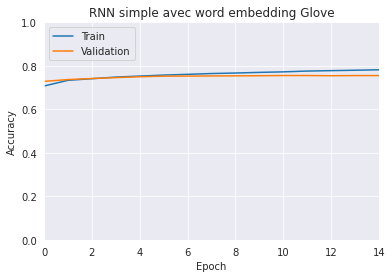

In [ ]:
plt.xlim([0, 14])
plt.ylim([0, 1])
plt.plot(history_A.history['accuracy'])
plt.plot(history_A.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN simple avec word embedding Glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

0.78 pour un modèle simple. Ce n'est pas mal ! voyons si on peut faire mieux avec un modèle plus complexe

In [ ]:
history_A.history['accuracy'][-1]

0.7832124829292297

## Premier modèle : Ajouts de couches

Maintenant que nous avons notre baseline, nous allons essayer de complexifier le modele pour avoir de meilleurs résultats. ajoutons quelque couches et changeons la couche LSTM en bidirectionelle

In [ ]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer_glv(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_B = tf.keras.Model(inputs, outputs)

In [ ]:
model_B.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 300)           19927800  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0   

In [ ]:
model_B.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
history_B = model_B.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 168s 1s/step - loss: 0.5709 - accuracy: 0.6973 - val_loss: 0.5327 - val_accuracy: 0.7273
Epoch 2/30
157/157 [==============================] - 162s 1s/step - loss: 0.5305 - accuracy: 0.7315 - val_loss: 0.5195 - val_accuracy: 0.7380
Epoch 3/30
157/157 [==============================] - 162s 1s/step - loss: 0.5147 - accuracy: 0.7436 - val_loss: 0.5209 - val_accuracy: 0.7388
Epoch 4/30
157/157 [==============================] - 161s 1s/step - loss: 0.5021 - accuracy: 0.7518 - val_loss: 0.5106 - val_accuracy: 0.7449
Epoch 5/30
157/157 [==============================] - 161s 1s/step - loss: 0.4901 - accuracy: 0.7612 - val_loss: 0.5119 - val_accuracy: 0.7440
Epoch 6/30
157/157 [==============================] - 162s 1s/step - loss: 0.4815 - accuracy: 0.7656 - val_loss: 0.5123 - val_accuracy: 0.7440
Epoch 7/30
157/157 [==============================] - 161s 1s/step - loss: 0.4724 - accuracy: 0.7723 - val_loss: 0.5133 - val_accuracy: 0.7447

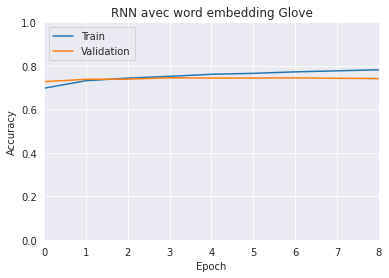

In [ ]:
plt.xlim([0, 8])
plt.ylim([0, 1])
plt.plot(history_B.history['accuracy'])
plt.plot(history_B.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN avec word embedding Glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

Les résultats sont plus ou moins similaires, ajouter des couches ne semble pas aider dans notre cas 

 ## Deuxieme modele : RNN avec FastText

On va maintenant essayer le même modèle que le premier mais en changeant la couche embedding

On telecharge Fastext

In [ ]:
!kaggle datasets download -d vsmolyakov/fasttext

fasttext.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/fasttext.zip"

Archive:  /content/fasttext.zip
replace wiki.simple.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
f = codecs.open('/content/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

111052it [00:12, 8802.27it/s]

found 111052 word vectors


In [ ]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(66426, 300)

In [ ]:
embedding_layer_fasttext = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer_fasttext(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_C = tf.keras.Model(inputs, outputs)

In [ ]:
model_C.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 30, 300)           19927800  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

In [ ]:
model_C.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
history_C = model_C.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 165s 1s/step - loss: 0.6009 - accuracy: 0.6674 - val_loss: 0.5571 - val_accuracy: 0.7115
Epoch 2/30
157/157 [==============================] - 159s 1s/step - loss: 0.5537 - accuracy: 0.7120 - val_loss: 0.5409 - val_accuracy: 0.7220
Epoch 3/30
157/157 [==============================] - 160s 1s/step - loss: 0.5344 - accuracy: 0.7290 - val_loss: 0.5339 - val_accuracy: 0.7266
Epoch 4/30
157/157 [==============================] - 159s 1s/step - loss: 0.5215 - accuracy: 0.7392 - val_loss: 0.5328 - val_accuracy: 0.7293
Epoch 5/30
157/157 [==============================] - 159s 1s/step - loss: 0.5107 - accuracy: 0.7465 - val_loss: 0.5300 - val_accuracy: 0.7292
Epoch 6/30
157/157 [==============================] - 159s 1s/step - loss: 0.5002 - accuracy: 0.7545 - val_loss: 0.5314 - val_accuracy: 0.7296
Epoch 7/30
157/157 [==============================] - 159s 1s/step - loss: 0.4916 - accuracy: 0.7605 - val_loss: 0.5351 - val_accuracy: 0.7282

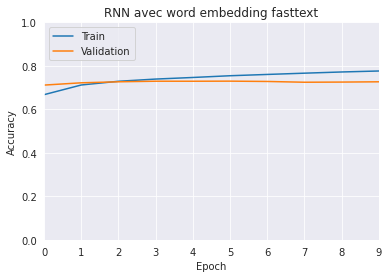

In [ ]:
plt.xlim([0, 9])
plt.ylim([0, 1])
plt.plot(history_C.history['accuracy'])
plt.plot(history_C.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN avec word embedding fasttext') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
history_C.history['accuracy']

[0.6674437522888184,
 0.7119812369346619,
 0.72904372215271,
 0.7392187714576721,
 0.7465312480926514,
 0.7545312643051147,
 0.7604687213897705,
 0.7662875056266785,
 0.7718312740325928,
 0.7763187289237976]

Les résultats sont également plus ou moins similaire au modele simple

# Troisieme modèle : RNN (glove) avec stematization

Essayons maintenant le meilleur modele mais avec une stematisation a la place de la  lemmatization pour voir si il y a une différence notable 

In [ ]:
X_train_stem, X_test_stem, y_train_stem, y_test_stem = sklearn.model_selection.train_test_split(df_preprocess['tweet_stemmatize'], df_preprocess['target'], test_size=0.2, random_state=123)


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_stem = pad_sequences(tokenizer.texts_to_sequences(X_train_stem),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test_stem = pad_sequences(tokenizer.texts_to_sequences(X_test_stem),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (160000, 30)
Testing X Shape: (40000, 30)


In [ ]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer_fasttext(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_D = tf.keras.Model(inputs, outputs)

In [ ]:
model_D.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 30, 300)           19927800  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0   

In [ ]:
model_D.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
history_D = model_D.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 164s 1s/step - loss: 0.6003 - accuracy: 0.6687 - val_loss: 0.5563 - val_accuracy: 0.7110
Epoch 2/30
157/157 [==============================] - 159s 1s/step - loss: 0.5529 - accuracy: 0.7134 - val_loss: 0.5454 - val_accuracy: 0.7206
Epoch 3/30
157/157 [==============================] - 157s 1s/step - loss: 0.5354 - accuracy: 0.7275 - val_loss: 0.5347 - val_accuracy: 0.7268
Epoch 4/30
157/157 [==============================] - 158s 1s/step - loss: 0.5221 - accuracy: 0.7380 - val_loss: 0.5310 - val_accuracy: 0.7313
Epoch 5/30
157/157 [==============================] - 157s 1s/step - loss: 0.5127 - accuracy: 0.7448 - val_loss: 0.5399 - val_accuracy: 0.7220
Epoch 6/30
157/157 [==============================] - 158s 1s/step - loss: 0.5006 - accuracy: 0.7550 - val_loss: 0.5334 - val_accuracy: 0.7296
Epoch 7/30
157/157 [==============================] - 158s 1s/step - loss: 0.4914 - accuracy: 0.7603 - val_loss: 0.5342 - val_accuracy: 0.7307

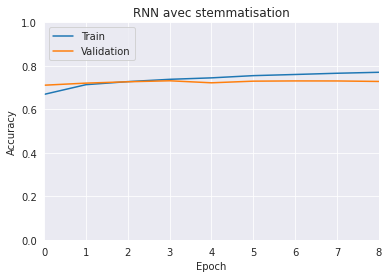

In [ ]:
plt.xlim([0,8])
plt.ylim([0, 1])
plt.plot(history_D.history['accuracy'])
plt.plot(history_D.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN avec stemmatisation')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

Nos modèles étant tous sensiblement équivalent, on pourrait déployer n'importe lequel des quatre. prenons celui qui a la meilleure précision

On sauve maintenant le modele pour pouvoir le déployer sur azure plus tard. On le sauvegardera en local pour l'utiliser dans le script du déploiement

In [ ]:
model_A.save('/content/drive/MyDrive/P7/model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/P7/model/assets


# Résumé

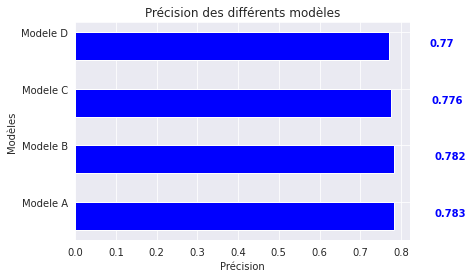

In [ ]:
x = ["Modele A", 'Modele B', 'Modele C', 'Modele D']
y = [round(history_A.history['accuracy'][-1],3),round(history_B.history['accuracy'][-1],3),round(history_C.history['accuracy'][-1],3),round(history_D.history['accuracy'][-1],3)]
fig, ax = plt.subplots()    
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Précision des différents modèles')
plt.xlabel('Précision')
plt.ylabel('Modèles')

for i, v in enumerate(y):
    ax.text(v+0.1, i, str(v), color='blue', fontweight='bold')


Tout les modèles sont plus ou moins similaires, nos tentatives d'amélioration n'ont pas été fructueuse mais la précision reste bonne 

# Déploiement dans le cloud

In [ ]:
pip install azureml-core

In [ ]:
from azureml.core import Workspace

Je me connecte a mon environnement

In [ ]:
ws = Workspace(subscription_id="715a2323-3efe-463c-8fcd-30a7c50758c2",
               resource_group="OpenClassrooms",
               workspace_name="p7_modele_avance")

Je charge le modèle puis l'enregistre sur Azure

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/P7/model')

In [ ]:
chemin_modele = "/content/drive/MyDrive/P7/model"

In [ ]:
from azureml.core.model import Model

# Register model
model = Model.register(ws, model_name="ultimate", model_path=chemin_modele)

Registering model ultimate


In [ ]:
print(model.name, model.id, model.version, sep='\t')

ultimate	ultimate:5	5


In [ ]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig


Même si elle n'est pas utilisé dans le notebook je met une copie ci dessous du score.py envoyer un initier la requête et recupérer la réponse du modèle

In [ ]:
import tensorflow as tf
import json
import joblib
import numpy as np
from azureml.core.model import Model
from azureml.core import Workspace
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import pickle
import nltk


# Called when the service is loaded
def init():
    global tokenizer
    global modele
    # load model
    model_root = Model.get_model_path('ultimate')
    modele=tf.keras.models.load_model(model_root)
    # tokenizer
    token_file = open(os.path.join(model_root, 'tokenizer.pickle'), 'rb')
    tokenizer = pickle.load(token_file)
    
# Called when a request is received
def run(raw_data):
    print(raw_data)
    

    tokeniz = nltk.RegexpTokenizer(r'\w+')
    raw_data = tokeniz.tokenize(raw_data)

    # Tokenize texte
    x_test = pad_sequences(tokenizer.texts_to_sequences([raw_data]), maxlen=30)
    # Prediction
    score = modele.predict([x_test])[0]
    # Sentiment
    sentiment = 'neutral'
    if score <= 0.4: 
        sentiment = "negatif"
    elif score >= 0.6: 
        sentiment = "positif"

    return {"score": float(score),"sentiment": sentiment}  

Je définis les dépendances de l'environnement virtuel sur le cloud

In [ ]:
env = Environment(name='myenv')
python_packages = ['nltk', 'numpy','tensorflow']
for package in python_packages:
    env.python.conda_dependencies.add_pip_package(package)

inf_config = InferenceConfig(environment=env, source_directory='/content/drive/MyDrive/P7/source_dir', entry_script='./echo_score.py')

Maintenant, nous allons définir la machine que l'on veut qui s'occupe du service. la plus petite possible est le mieux car elle aura très peu de trafic a gérer

In [ ]:
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "tweets",  "method" : "CNN"}, 
                                               description='Sentiment detection of tweets')


In [ ]:
model = Model(ws, 'ultimate')

On ce connecte a l'environnement préfini avant "myenv"

In [ ]:
myenv = Environment.get(workspace=ws, name="myenv", version="1")

In [ ]:
myenv.inferencing_stack_version = "latest"

In [ ]:
service = Model.deploy(workspace=ws, 
                       name='service', 
                       models=[model], 
                       inference_config=inf_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-09-22 19:57:11+00:00 Creating Container Registry if not exists.
2021-09-22 19:57:12+00:00 Registering the environment.
2021-09-22 19:57:14+00:00 Use the existing image.
2021-09-22 19:57:14+00:00 Generating deployment configuration.
2021-09-22 19:57:15+00:00 Submitting deployment to compute..
2021-09-22 19:57:23+00:00 Checking the status of deployment service..
2021-09-22 20:00:01+00:00 Checking the status of inference endpoint service.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [ ]:
print(service.scoring_uri)

http://f3328218-a29d-41bd-9df4-5f7f647a6363.westeurope.azurecontainer.io/score


In [ ]:
import requests
import json

uri = service.scoring_uri
requests.get(service.scoring_uri)
headers = {"Content-Type": "application/json"}
raw_data = {
    "query":"the food was horrible. really sad !",
}
data = json.dumps(raw_data)
response = requests.post(uri, data=raw_data, headers=headers)
print(response.json())


{'score': 0.18462970852851868, 'sentiment': 'negatif'}


In [ ]:
import requests
import json

uri = service.scoring_uri
requests.get(service.scoring_uri)
headers = {"Content-Type": "application/json"}
raw_data = {
    "query":"That was a really pleasant flight",
}
data = json.dumps(raw_data)
response = requests.post(uri, data=raw_data, headers=headers)
print(response.json())


{'score': 0.8108097910881042, 'sentiment': 'positif'}


# Méthode 1 : Microsoft Azure cognitive API

In [ ]:
pip install azure-ai-textanalytics==5.1.0b7

In [ ]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

On charge la clé propre au service dédié puis on fait un appel pour tester si tout fonctionne correctement

In [ ]:
Key_1 = open('/content/drive/MyDrive/P7/Key.txt', encoding='utf-8-sig')
key = Key_1.read()

On ce connecte au service

In [ ]:
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint="https://cognitivesservice.cognitiveservices.azure.com", 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

On fait la requête

In [ ]:
def sentiment_analysis_example(client):

    documents = ["I had the best day of my life. The only bad part is that you were here."]
    response = client.analyze_sentiment(documents=documents)[0]
    print("Document Sentiment: {}".format(response.sentiment))
    print("Overall scores: positive={0:.2f}; neutral={1:.2f}; negative={2:.2f} \n".format(
        response.confidence_scores.positive,
        response.confidence_scores.neutral,
        response.confidence_scores.negative,
    ))
    for idx, sentence in enumerate(response.sentences):
        print("Sentence: {}".format(sentence.text))
        print("Sentence {} sentiment: {}".format(idx+1, sentence.sentiment))
        print("Sentence score:\nPositive={0:.2f}\nNeutral={1:.2f}\nNegative={2:.2f}\n".format(
            sentence.confidence_scores.positive,
            sentence.confidence_scores.neutral,
            sentence.confidence_scores.negative,
        ))
          
sentiment_analysis_example(client)



Document Sentiment: mixed
Overall scores: positive=0.50; neutral=0.00; negative=0.50 

Sentence: I had the best day of my life.
Sentence 1 sentiment: positive
Sentence score:
Positive=1.00
Neutral=0.00
Negative=0.00

Sentence: The only bad part is that you were here.
Sentence 2 sentiment: negative
Sentence score:
Positive=0.00
Neutral=0.00
Negative=1.00



# Méthode 2 : Modèle sur mesure simple

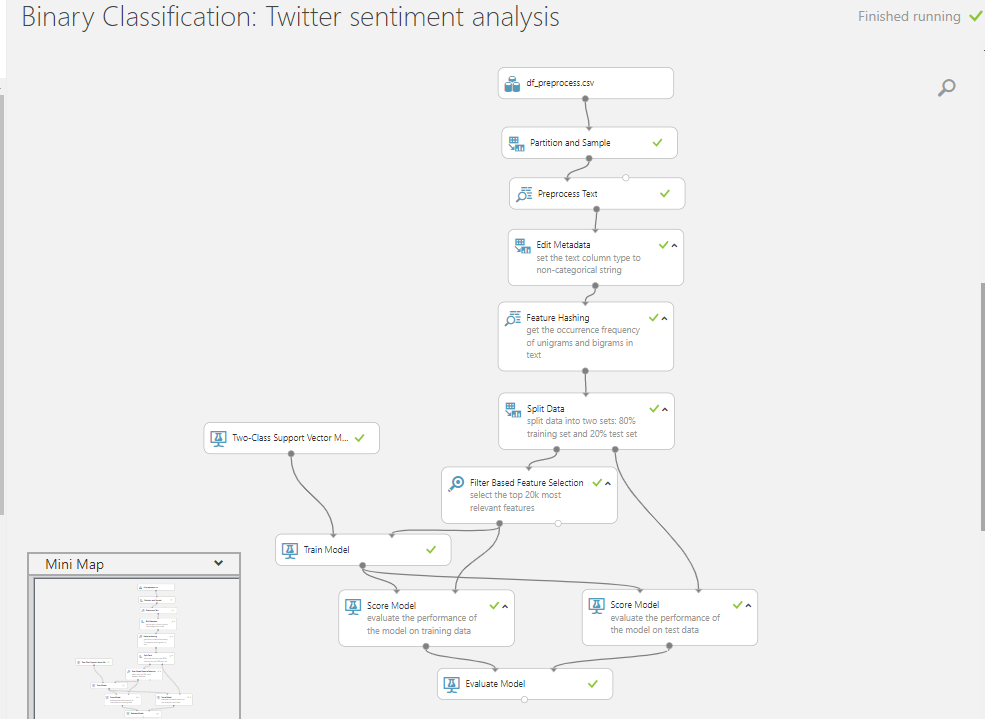

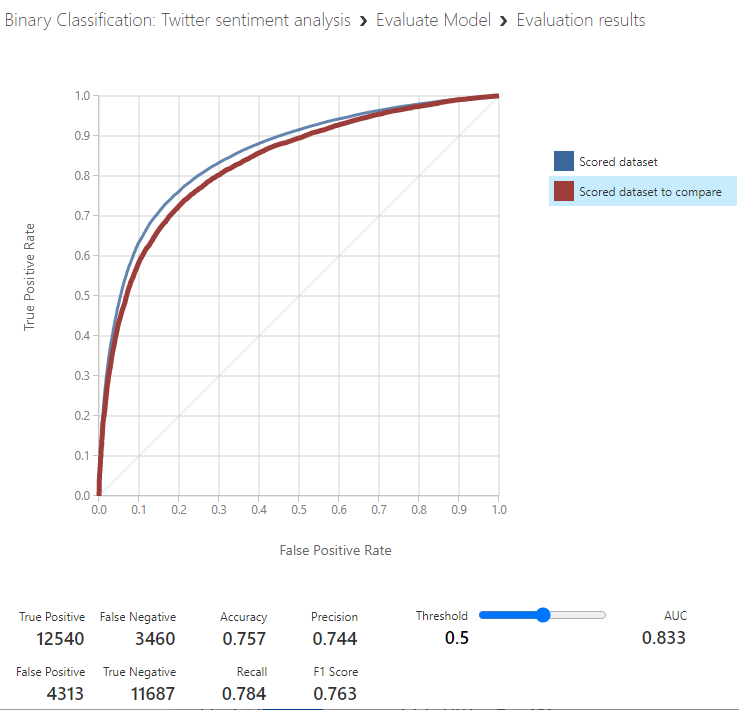